# IREN Competition 1  <a class="anchor" id="top-notebook"></a>

Handmade convolutional neural network for ships classification.

The project description can be found <a href=http://www.ricou.eu.org/iren/notes_rn.html#Projet%20navires%202021>here</a>.

Members:
* Louis Guo
    * login: louis.guo
* Ilan Guenet
    * login: ilan.guenet
    * <a href=https://github.com/Li0nMo0se>github</a>
   
## Table of content:
* [Check data](#check-data)
* [Setup data](#setup-data)
* [Data augmentation](#data-augmentation)
* [Model creation](#model-creation)
* [Model training](#training)
* [Model accuracy](#model-accuracy)
* [Submission](#submission)
* [More images](#more-images)

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import os
import skimage
from skimage import io

# Seed
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

%matplotlib inline

# Autocompletion
%config Completer.use_jedi = False

In [2]:
# Files architecture
path_train = "ships_scaled/train"
path_test = "ships_scaled/test"
submission_file = "test.npy"

## Check data <a class="anchor" id="check-data"></a>
[Table of content](#top-notebook)

In this part, we are going to get information of the training, test and submission data. We are also going to plot images to see how they look like.

In [3]:
!tar xzf /kaggle/input/shipsmano2021/ships.tgz
!ls /kaggle/working

__notebook_source__.ipynb  ships_scaled  test.npy


We first write a function that loads data from the input data folder.

After several loads, we found out that the data set is corrupted. There are RGB images and grayscale images. We want our network to work on RGB images only. In this case, there are two options. The first one is to simply remove the grayscale images. The second one is to transform the grayscale image to an RGB image by duplicating the single channel into three RGB channels. We chose to remove the grayscale images since there are only a few of them (107  over 47562 images) and the second solution might mislead the convolutional neural network and thus lower its accuracy.

In [4]:
def is_rgb_shape(im):
    return len(im.shape) == 3 and im.shape[2] == 3

def get_info_clean_data(path_data):
    """
    Load data from a directory
    Get info of the data
    Clean the data if necessary
    
    Return:
        * A list of images
        * A list of labels corresponding to the list of images
        * A dataframe describing the images
        * A map of label to class/category name
    """
    curr_label = 0
    label_to_category = dict()

    labels = []
    imgs = []
    info = []

    for dirname in np.sort(os.listdir(path_data)):
        label_to_category[curr_label] = dirname

        dirname = os.path.join(path_data, dirname)
        for filename in os.listdir(dirname):
            filename = os.path.join(dirname, filename)

            img = skimage.io.imread(filename)
            # The image is not an rgb image and thus not append
            if not is_rgb_shape(img):
                os.remove(filename)
                continue

            imgs.append(img)
            info.append([filename, curr_label, img.shape[0], img.shape[1], img.dtype])
            labels.append(curr_label)

        curr_label += 1

    labels = np.array(labels)
    df_input = pd.DataFrame(info, columns=["filename", "category", "width", "height", "dtype"])
    return imgs, labels, df_input, label_to_category

In [5]:
imgs, labels, df_input, label_to_category = get_info_clean_data(path_train)

In [6]:
print(f"Number of categories: {len(label_to_category)}")
# Warning, label_to_category must be sorted by categories' name in the alphabetical order
label_to_category

Number of categories: 13


{0: 'coastguard',
 1: 'containership',
 2: 'corvette',
 3: 'cruiser',
 4: 'cv',
 5: 'destroyer',
 6: 'ferry',
 7: 'methanier',
 8: 'sailing',
 9: 'smallfish',
 10: 'submarine',
 11: 'tug',
 12: 'vsmallfish'}

The categories of ships are listed below:

|  id | category name  |
|---|---|
| 0  | coastguard |
| 1  | containership |
| 2  | corvette  |
| 3  | cruiser  |
| 4  | cv  |
| 5  | destroyer |
| 6  | ferry  |
| 7  | methanier  |
| 8  | sailing  |
| 9  | smallfish  |
| 10 | submarine  |
| 11 | tug  |
| 12 | vsmallfish  |

Let's show some images now. An image for each category is showed.

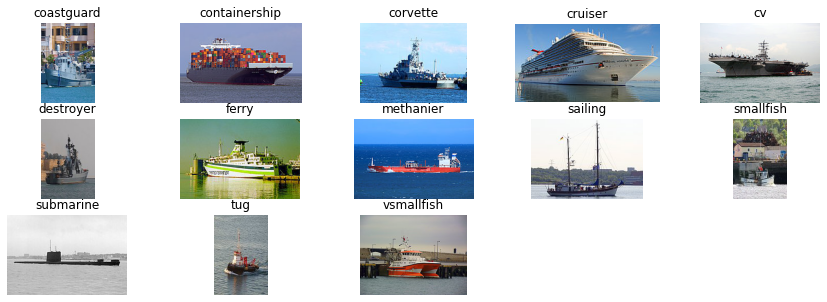

In [7]:
plt.figure(figsize=(15,5))
nb_image_row = 5
for i in range(len(label_to_category)):
    plt.subplot(3, 5, i + 1)
    plt.title(label_to_category[i])
    plt.imshow(imgs[np.argmax(labels==i)])
    plt.axis('off')

plt.show()

We can already notice that images have different shapes. So, we should dive deeper in the metadata of the input.

In [8]:
df_input

,filename,category,width,height,dtype
0,ships_scaled/train/coastguard/1483.jpg,0,192,128,uint8
1,ships_scaled/train/coastguard/345.jpg,0,192,128,uint8
2,ships_scaled/train/coastguard/3636.jpg,0,192,128,uint8
3,ships_scaled/train/coastguard/2410.jpg,0,192,128,uint8
4,ships_scaled/train/coastguard/2246.jpg,0,192,128,uint8
...,...,...,...,...,...
47450,ships_scaled/train/vsmallfish/2649.jpg,12,134,210,uint8
47451,ships_scaled/train/vsmallfish/499.jpg,12,140,210,uint8
47452,ships_scaled/train/vsmallfish/2506.jpg,12,158,210,uint8
47453,ships_scaled/train/vsmallfish/1987.jpg,12,131,210,uint8


In [9]:
print(f"Minimum input width {df_input.width.min()}, maximum input width {df_input.width.max()}")
print(f"Minimum input height {df_input.height.min()}, maximum input height {df_input.height.max()}")

Minimum input width 46, maximum input width 192
Minimum input height 128, maximum input height 210


In [10]:
print("{:.2f}".format(df_input.width[df_input.width < df_input.width.max()].count() / df_input.width.count() * 100), end='')
print("% of the images have a different width than the maximum width")

print("{:.2f}".format(df_input.height[df_input.height < df_input.height.max()].count() / df_input.height.count() * 100), end='')
print("% of the images have a different height than the maximum height")

67.14% of the images have a different width than the maximum width
35.23% of the images have a different height than the maximum height


<AxesSubplot:xlabel='width,height'>

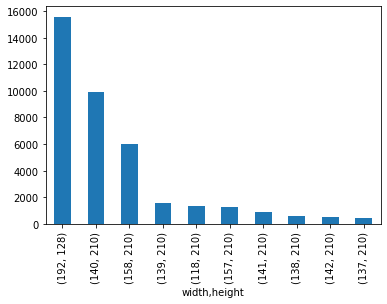

In [11]:
groups = df_input.groupby(['width', 'height']).size()
groups.sort_values(ascending=False, inplace=True)
# Plot the 10 most relevant shapes
groups[:10].plot.bar()

As showed in the histogram, input images have many different shapes. However there are three main shapes that stand out which are respectively (192, 128), (140, 210) and (158, 210).

[]

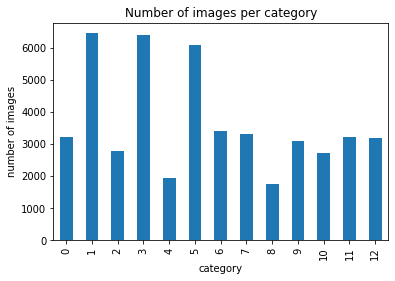

In [12]:
# Plot number of images per category
ax = df_input.category.value_counts(sort=False).plot.bar()
ax.set_xlabel('category')
ax.set_ylabel('number of images')
ax.set_title("Number of images per category")
ax.plot()

We can also notice that the set of images is unbalanced according to the categories.

Now, let's see how the submission data look like

In [13]:
X_submission = np.load('/kaggle/working/test.npy', allow_pickle=True)
X_submission = X_submission.astype('float32') / 255

X_submission.shape, X_submission.dtype

((1270, 128, 192, 3), dtype('float32'))

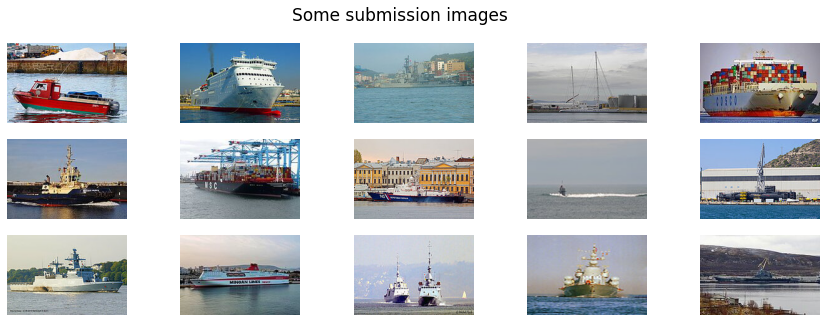

In [14]:
ax = plt.figure(figsize=(15,5))
nb_image_row = 5
plt.suptitle('Some submission images', fontsize=17)
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_submission[np.random.randint(len(X_submission))])
    plt.axis('off')
plt.show()

All the submission data has the same shape which is (128, 192, 3) and the dtype is float32. We need to make our input data comply with the submission data.

In this case, we need a preprocess step. We are going to use keras.ImageDataGenerator which is going to do the job of preprocessing automatically. 

## Setup data <a class="anchor" id="setup-data"></a>
[Table of content](#top-notebook)

We need to split the set of images into three sets:
 * **train set**: data used to train the model (improve the model accuracy).
 * **validation set**: test the model accuracy during the training.
 * **test set**: test the model accuracy after the training.
 
As we are going to use a keras.ImageDataGenerator, it will handle the train set, validation set and test set automatically. However, it is still required to to split the data into two directories:
* Test data will be located in `ships_scaled/test`. In order to be fair with the test data, we want the same number of images for each category.
* Train/validation data will be located in `ships_scaled/train`.

In [15]:
# The directory ships_scaled/train already exists and already contains all the images
# Create the ships_scaled/test directory and moved some images
# from train directory to this directory
!mkdir ships_scaled/test

In [16]:
def setup_data(dir_input, dir_output, label_to_category, nb_test_img_per_category=None):
    """
    Move some images from an input directory to an output directory
    
    Arguments:
        * dir_input: the input directory
        * dir_output: the output directory
        * label_to_category: used to get the category name (thus the directory name)
        * nb_test_img_per_category: number of images per category
    """
    for label, class_name in label_to_category.items():
        class_path = os.path.join(dir_input, class_name)
        new_class_path = os.path.join(dir_output, class_name)
        os.mkdir(new_class_path)
        
        # If None, move everything
        for filename in os.listdir(class_path)[:nb_test_img_per_category]:
            os.rename(os.path.join(class_path, filename),
                      os.path.join(new_class_path, filename))

In [17]:
# Test data will have 100 of images for each category
setup_data(path_train,
           path_test,
           label_to_category,
           nb_test_img_per_category=100)

In [18]:
!ls ships_scaled/test

coastguard     corvette  cv	    ferry      sailing	  submarine  vsmallfish
containership  cruiser	 destroyer  methanier  smallfish  tug


## Data augmentation<a class="anchor" id="data-augmentation"></a>
[Table of content](#top-notebook)

**Data augmentation** is a way to improve the dataset as input images are going to be randomly modified. ImageDataGenerators from keras are going to be used. We are going to have two generators a test ``test_datagen`` and a ``train_datagen``. The last generator is going to have more work as it is going to be used for the training and we want more diversity in the training set. 

Moreover, the neural network needs the input shape and input data type to be same for every image. In this case, input images must all be **preprocessed**. Two operations are performed:
* **Resizing** to the input shape. In order to improve the neural network efficiency, all the images are resized as a square (128, 128) images. After a several training, it showed more efficiency on the prediction of the submission dataset.
* **Rescaling** between [0;1].

An automatic way of preprocessing input images is to ask the generator to do it.

The generators also **load data on the fly**, which avoid memory issues. Images are saved in directories. Then, the generator will automatically load the image and find its category (from the directory name).

Finally, one of the feature of the generator is to automatically **split training data and validation data**.

To recap, the generators will do the following work:
* preprocess input (always)
* load data on the fly (always)
* data augmentation (if needed)
* split training and validation data (if needed)

In [19]:
# Target shape is a square shape for more efficiency and better accuracy
min_ = min(X_submission.shape[1:3])
target_shape = (min_, min_)
target_shape

(128, 128)

### ImageDataGenerator for test set

The test set is here only to test the neural network accuracy. Thus, it is not needed to apply some random modifications to these images meaning data augmentation is not needed. Also, data are not split. The test images will be saved in order to check them after a prediction.

In [20]:
path_gen_test = "gen_test"
!mkdir gen_test

In [21]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  dtype='float32')

# Categories are sorted by alphabetical order
test_generator = test_datagen.flow_from_directory(
        path_test,
        target_size=target_shape,
        seed=SEED,
        shuffle=False,
        save_to_dir=path_gen_test,
        save_format="jpeg",
        interpolation="bicubic")

Found 1300 images belonging to 13 classes.


### ImageDataGenerator for train/validation set

Besides the preprocessing and load on the fly, the generator for the train/validation data set will have two more tasks.

It will split the dataset into a train set and a validation set. In this notebook, 10% of the images will be exclusively used for validation. On the other hand, 90% of the images will be exclusively used for training.

The generator will also do some data augmentation. Data augmentation is a technique to create new training data (diversifying data) from existing training data by modifying data with imaging operations. The operations are performed randomly in order to get many similar but different images that will likely be seen by the model. This technique often improves neural network accuracy and robustness.

Here, a **horizontal flip** is processed. The input image might be flip from left to right. The orientation of the ships should not matter in ship classification. However, a vertical flip is bad because the sea would be located at the top of the image and the ship at the bottom. This situation will never happen in the real world, so this can be omitted.

In [22]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   horizontal_flip=True,
                                   validation_split=0.1,
                                   dtype='float32')

# Categories are sorted by alphabetical order
train_generator = train_datagen.flow_from_directory(
        path_train,
        batch_size=128,
        target_size=target_shape,
        seed=SEED,
        subset="training",
        interpolation="bicubic")

# Categories are sorted by alphabetical order
validation_generator = train_datagen.flow_from_directory(
        path_train,
        batch_size=128,
        target_size=target_shape,
        seed=SEED,
        subset="validation",
        interpolation="bicubic")

Found 41545 images belonging to 13 classes.
Found 4610 images belonging to 13 classes.


In [23]:
from keras.models import Sequential
from keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip

# Also used for the predictions of the submission images
model_resize = Sequential(
    [Rescaling(1.0 / 255),
     Resizing(target_shape[0], target_shape[1], interpolation="bicubic")])

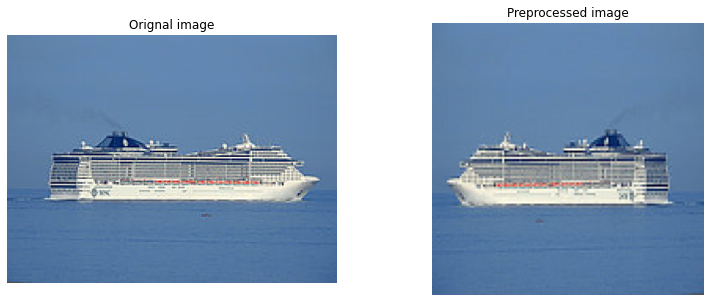

In [24]:
# You can see here a quick example of the preprocessing step on an image
np.random.seed(SEED)
rand_img = np.random.randint(len(imgs))

plt.figure(figsize=(13,5))

plt.subplot(1, 2, 1)
plt.imshow(imgs[rand_img])
plt.title("Orignal image")
plt.axis('off')

# Apply preprocessing
# Expand to comply with tensorflow array
res_preprocess = np.expand_dims(imgs[rand_img], axis=0)
res_preprocess = model_resize(res_preprocess) # resize and rescale

while True: # Radomly flip until really flip
    to_flip = RandomFlip(mode='horizontal', seed=SEED)(res_preprocess).numpy()
    if not np.allclose(to_flip, res_preprocess):
        break

# Squeeze to comply with plt.imshow()
res_preprocess = np.squeeze(to_flip, axis=0)

plt.subplot(1, 2, 2)
plt.imshow(res_preprocess)
plt.title("Preprocessed image")
plt.axis('off')

plt.show()

## Model creation<a class="anchor" id="model-creation"></a>
[Table of content](#top-notebook)

We are going to create a **C**onvolutional **N**eural **N**etwork, also called CNN (<a href="https://en.wikipedia.org/wiki/Convolutional_neural_network">wiki</a>) with the following layers:

* **2D Convolution**: This layer creates a convolution kernel that is convolved with the layer input. The kernel size is (3,3) and the input is padded to retain the input shape.
* **MaxPooling2D**: Downsample the input by maximum operation.
* **Dense**: Fully connected layer.
* **BatchNormalization**: This layer maintains the mean output close to 0 and the output standard deviation close to 1. This operation makes the CNN to converge faster.
* **Dropout**: This layer avoids the model to overfit with the training data by randomly disabling some different nodes for each computation. The dropout rate is 10%.
* **GlobalAveragePooling2D**: This layer flattens several 2D arrays (spatial data) by computing the average of every array.

The model is a sequence of those layers. The architecture is a block architecture. There are three convolution blocks. A convolution block is a sequence of:

2D Convolution -> BatchNormalization -> 2D Convolution -> BatchNormalization -> MaxPooling2D -> Dropout

Feature maps are obtained from the three blocks. The feature maps of a CNN capture the result of applying the filters to an input image. Then a last block containing dense layers makes the prediction according to the feature maps. Besides for the last dense, the activation function of dense layers is **relu**. The activation function of the last dense is **softmax** because the output must be probabilities. The output of the CNN is probabilities of belonging to a category. The category with highest probability means the CNN predicted the input image to belong to this category. The softmax activation function is the most adapted for the last layer.

To connect the last convolution block with dense layers block, a GlobalAveragePooling2D is performed. After several training, this operation proves more efficiency than a regular flatten or GlobalMaxPooling2D.

For the **Optimizer**, the Adadelta optimizer (<a href="https://keras.io/api/optimizers/adadelta/">wiki</a>) is going to be used because it seems to be the most efficient.

Finally, after several training, the best **learning rate** seems to be 0.05. With this learning rate, the convergence is quite quick and the model learns well.

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adadelta

input_shape = (target_shape[0], target_shape[1], 3)
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_to_category), activation='softmax'))

model.compile(optimizer=Adadelta(learning_rate=0.05), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
print("Nombre de couches : ", len(model.layers))
model.summary()

Nombre de couches :  29
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (

## Model Training <a class="anchor" id="training"></a>
[Table of content](#top-notebook)

The model is simply **trained** with the training and validation data from the generators.

One **callback** is also used to make the training more convenient. It saves the best weights. Indeed, during the training, the accuracy might vary. Therefore, we want to save the best weights throughout the training. At the end of training, the best weights (with the greatest validation accuracy) are loaded into the model.

### Training

In [27]:
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'model_checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True,
                                            verbose=1)

In [28]:
nb_epochs = 30

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
model_history = model.fit(x=train_generator,
                          epochs=nb_epochs,
                          verbose=1,
                          validation_data=validation_generator,
                          callbacks=[model_checkpoint_callback])

Epoch 1/30
325/325 [==============================] - 116s 334ms/step - loss: 1.9385 - accuracy: 0.3683 - val_loss: 2.7035 - val_accuracy: 0.0998

Epoch 00001: val_accuracy improved from -inf to 0.09978, saving model to model_checkpoint
Epoch 2/30
325/325 [==============================] - 104s 320ms/step - loss: 1.1123 - accuracy: 0.6289 - val_loss: 1.7599 - val_accuracy: 0.4707

Epoch 00002: val_accuracy improved from 0.09978 to 0.47072, saving model to model_checkpoint
Epoch 3/30
325/325 [==============================] - 104s 321ms/step - loss: 0.8086 - accuracy: 0.7301 - val_loss: 1.0770 - val_accuracy: 0.6531

Epoch 00003: val_accuracy improved from 0.47072 to 0.65315, saving model to model_checkpoint
Epoch 4/30
325/325 [==============================] - 104s 321ms/step - loss: 0.6305 - accuracy: 0.7900 - val_loss: 1.0361 - val_accuracy: 0.6859

Epoch 00004: val_accuracy improved from 0.65315 to 0.68590, saving model to model_checkpoint
Epoch 5/30
325/325 [=======================

In [29]:
model_path = "output_model"

In [30]:
from keras.models import load_model
# Load the model
# model = load_model("output_model")
# model.summary()

### Check training results

It is now time to see the result of the training step. History of the training is put in a DataFrame. Then, we plot the **train accuracy** and **validation accuracy** over epoch

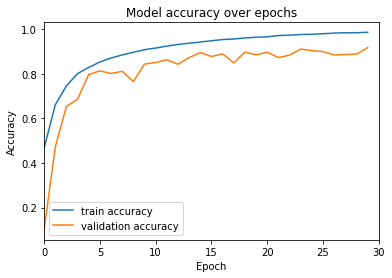

In [31]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim([0, nb_epochs])
plt.legend(['train accuracy', 'validation accuracy'], loc='best')
plt.show()

In the beginning of the training, the validation and train accuracy increased quickly until around the fifth epoch. Then, the two accuracies keep increasing, but much slower. The train accuracy increased slightly more than the validation accuracy. At the end of the training, the train accuracy is equal to 98%. It means the model has learned very accurately the train set. However, the important indicator is the validation accuracy. This was computed on images not used to teach the neural network. The final validation accuracy is equal to 91%. There is a difference of 7% between the train accuracy and validation accuracy. It is very much reasonable. The CNN did not overfit the training data. Moreover, the validation accuracy is high. To recap, the CNN converge to a high validation accuracy.

## Model accuracy <a class="anchor" id="model-accuracy"></a>
[Table of content](#top-notebook)

Here is the crucial moment. Let's evaluate the accuracy of the model. The evaluation is performed on the test data only. As a reminder, there is a 100 images for each category.

First, the **model accuracy** is checked. One evaluation is performed. The evaluated model is the model with the best computed weights.

After this step, the best model is loaded. Then, the **confusion matrix** is plotted. Some interpretations might become possible thanks to this matrix.

Finally, a **classification report** is generated to get a summary of the model classification capabilities.

### Compute accuracy

The **accuracy** is computed this way: $$Accuracy = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} $$ 

In [32]:
# Load the best model
# The model weights (that are considered the best) are loaded into the model.
# DO NOT LOAD if no checkpoint.
model.load_weights(checkpoint_filepath)

In [33]:
metrics = model.evaluate(test_generator)
print("The model accuracy over the test data %.2f%%"%(metrics[1] * 100))

41/41 [==============================] - 4s 95ms/step - loss: 0.2845 - accuracy: 0.9277
The model accuracy over the test data 92.77%


In [34]:
# Save the model
model.save(filepath=model_path)

### Confusion Matrix

A confusion matrix usage is to evaluate the quality of the output of a classifier. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

The true labels are represented by the rows and the predictions by the columns.

Documentation:
 * scikit-learn documentation of confusion matrix <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html">here</a>.

In [35]:
import seaborn as sn

def my_plot_confusion_matrix(conf_matrix, classes, title=None):
    df_cm = pd.DataFrame(conf_matrix, classes, classes)
    plt.figure(figsize=(10,5))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, cmap='Oranges', fmt='g', annot=True, annot_kws={"size": 11}) # font size
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if title:
        plt.title(title)

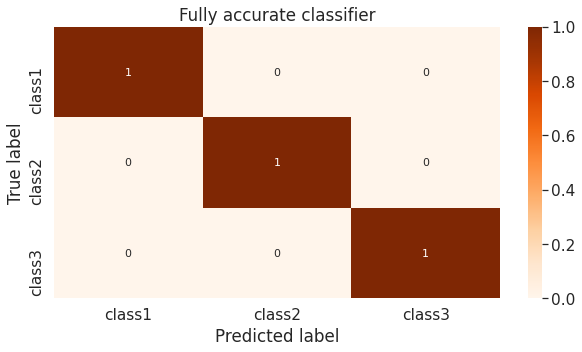

In [36]:
example_classes = ['class1', 'class2', 'class3']
example_val = np.identity(3)
my_plot_confusion_matrix(example_val, example_classes, title="Fully accurate classifier")

In [37]:
from sklearn.metrics import confusion_matrix

# compute the confusion matrix of the model
y_pred = model.predict(test_generator).argmax(axis=1)
conf_matrix = confusion_matrix(test_generator.classes, y_pred)

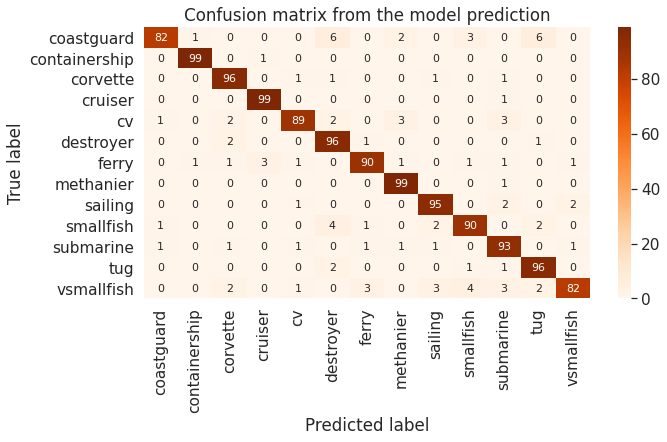

In [38]:
my_plot_confusion_matrix(conf_matrix, label_to_category.values(),
                         title="Confusion matrix from the model prediction")

### Classfication report

As a reminder:

The **precision** for a class is the number of correctly predicted images of this class out of all predicted images of this class.

The **recall** for a class is the number of correctly predicted images of this class out of the number of actual images of this class.

The **f1-score** is the combination of the precision score and the recall score such that $$\text{f1 score} = 2\frac{\text{precision}  \times \text{recall}}{\text{precision} + \text{recall}}$$ It tries to compromise the precision with the recall.

The closer these scores get to 1, the more accurate the model is.

The blue rectangle represents the recall of class1
The green rectangle represents the precision of class1


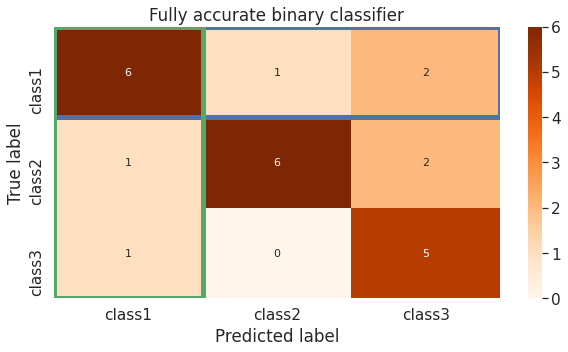

In [39]:
import matplotlib.patches as patches

example_val = np.array([[6, 1, 2], [1, 6, 2], [1, 0, 5]])
my_plot_confusion_matrix(example_val, example_classes, title="Fully accurate binary classifier")
ax = plt.gca()
# Add the patch to the Axes
ax.add_patch(patches.Rectangle((0, 0), 3, 1, linewidth=5, edgecolor='b', facecolor='none'))
ax.add_patch(patches.Rectangle((0, 0), 1, 3, linewidth=5, edgecolor='g', facecolor='none'))
print("The blue rectangle represents the recall of class1")
print("The green rectangle represents the precision of class1")

In [40]:
from sklearn.metrics import classification_report

print(classification_report(test_generator.classes,
                            y_pred,
                            target_names=label_to_category.values()))

               precision    recall  f1-score   support

   coastguard       0.96      0.82      0.89       100
containership       0.98      0.99      0.99       100
     corvette       0.92      0.96      0.94       100
      cruiser       0.96      0.99      0.98       100
           cv       0.95      0.89      0.92       100
    destroyer       0.86      0.96      0.91       100
        ferry       0.94      0.90      0.92       100
    methanier       0.93      0.99      0.96       100
      sailing       0.93      0.95      0.94       100
    smallfish       0.91      0.90      0.90       100
    submarine       0.88      0.93      0.90       100
          tug       0.90      0.96      0.93       100
   vsmallfish       0.95      0.82      0.88       100

     accuracy                           0.93      1300
    macro avg       0.93      0.93      0.93      1300
 weighted avg       0.93      0.93      0.93      1300



In the confusion matrix, there are high values on the diagonal which reflects the model accuracy. There are some categories that are very well predicted such as ``containership``, ``cruiser`` and ``methanier``. On the other hand, some categories are not as well predicted with a lower accuracy such as ``coastguard``, ``vsmallfish``. Overall, the model is quite balanced in category prediction and accurate.

### Check generated data

Here, the images generated by the test data generator are quickly checked.

In [41]:
def show_some_images(path_dir, title="images"):
    plt.figure(figsize=(20,8))
    i = 0
    for path_img in os.listdir(path_dir)[:15]:
        img = skimage.io.imread(os.path.join(path_dir, path_img))

        if i == 0:
            print("Shape of the " + title + ": ", img.shape)
            print("Data type of the " + title + ": ", img.dtype)

        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        i += 1

Shape of the Generated test images:  (128, 128, 3)
Data type of the Generated test images:  uint8


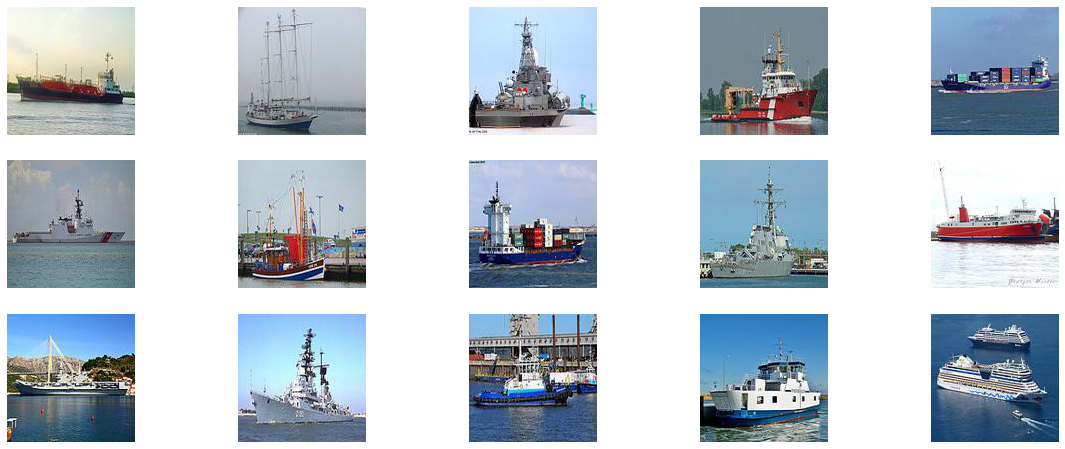

In [42]:
show_some_images(path_gen_test, "Generated test images")

The generated images seems to comply with the requirements.

## Submission <a class="anchor" id="submission"></a>
[Table of content](#top-notebook)

In this part, the submission to the competition is made. The submission images are loaded from the ``test.npy`` file. Then, the model predicts the category of the images. The result is stored in a CSV file. This CSV file is the submission file.

In [43]:
X_submission = np.load(submission_file, allow_pickle=True)

# Do not forget to preprocess input
X_submission = model_resize(X_submission).numpy()

X_submission.shape, X_submission.dtype

((1270, 128, 128, 3), dtype('float32'))

In [44]:
res = model.predict(X_submission).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="Id")

In [45]:
!head reco_nav.csv

Id,Category
0,0
1,11
2,11
3,11
4,1
5,8
6,11
7,5
8,0


In [46]:
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv

In [47]:
!rm -rf ships_scaled/ 
!rm -rf gen_test

## More images <a class="anchor" id="more-images"></a>
[Table of content](#top-notebook)

The model will now be evaluated on images we found ourselves. The dataset can be found <a href="https://www.kaggle.com/ilanguenet/shipsforepita">here</a>. The images were randomly picked no matter the strength and weakness of the model. It is another good way to test the model accuracy.

Before making the prediction, we check the images from the dataset. Then, the same analysis of the result as for the test set (explanations  [here](#model-accuracy)) is performed with:
* The accuracy of the model
* The confusion matrix
* The recall score, the precision score and the f1-score

In [48]:
# Move in working directory
!mkdir more_ships
!cp -r ../input/shipsforepita/ships/* more_ships
!ls more_ships

coastguard     corvette  cv	    ferry      sailing	  submarine  vsmallfish
containership  cruiser	 destroyer  methanier  smallfish  tug


In [49]:
# Get information
path_test_bis = "more_ships"
imgs_bis, labels_bis, df_input_bis, label_to_category_bis = get_info_clean_data(path_test_bis)

In [50]:
print(f"Number of categories: {len(label_to_category_bis)}")
# Warning, label_to_category must be sorted by categories' name in the alphabetical order
print(f"Same categories as the given dataset? {label_to_category_bis == label_to_category}")
print(f"Number of images: {len(imgs_bis)}.")

Number of categories: 13
Same categories as the given dataset? True
Number of images: 20.


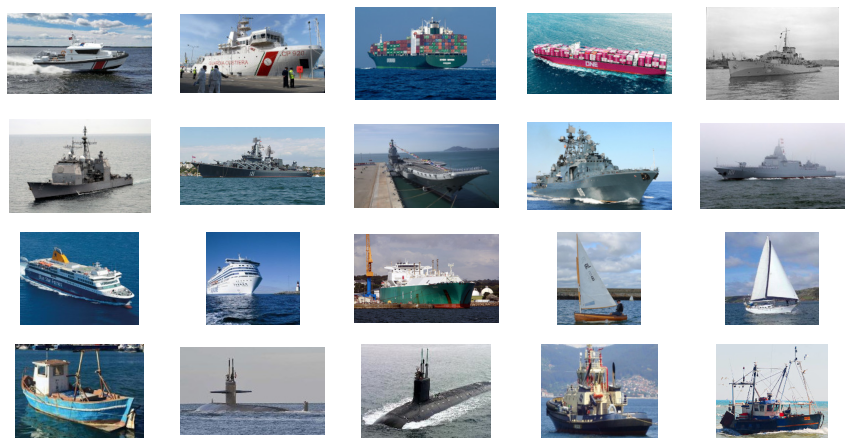

In [51]:
# Let's plot all the images
plt.figure(figsize=(15,10))
for i in range(len(imgs_bis)):
    plt.subplot((len(imgs_bis) // nb_image_row) + 1, nb_image_row, i + 1)
    plt.imshow(imgs_bis[i])
    plt.axis('off')
plt.show()

[]

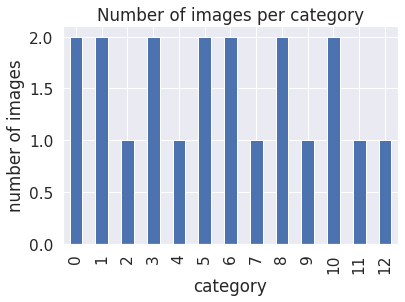

In [52]:
# Plot number of images per category
ax = df_input_bis.category.value_counts(sort=False).plot.bar()
ax.set_xlabel('category')
ax.set_ylabel('number of images')
ax.set_title("Number of images per category")
ax.plot()

In [53]:
# test_datagen rescale images

test_bis_generator = test_datagen.flow_from_directory(
        path_test_bis,
        target_size=target_shape,
        seed=SEED,
        shuffle=False,
        interpolation="bicubic")

Found 20 images belonging to 13 classes.


In [54]:
metrics = model.evaluate(test_bis_generator)
print("The model accuracy over the handmade dataset %.2f%%"%(metrics[1] * 100))

1/1 [==============================] - 0s 108ms/step - loss: 4.8151 - accuracy: 0.6500
The model accuracy over the handmade dataset 65.00%


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

   coastguard       1.00      0.50      0.67         2
containership       0.67      1.00      0.80         2
     corvette       0.25      1.00      0.40         1
      cruiser       0.00      0.00      0.00         2
           cv       0.00      0.00      0.00         1
    destroyer       1.00      0.50      0.67         2
        ferry       1.00      0.50      0.67         2
    methanier       1.00      1.00      1.00         1
      sailing       1.00      1.00      1.00         2
    smallfish       1.00      1.00      1.00         1
    submarine       0.50      1.00      0.67         2
          tug       0.00      0.00      0.00         1
   vsmallfish       1.00      1.00      1.00         1

     accuracy                           0.65        20
    macro avg       0.65      0.65      0.61        20
 weighted avg       0.68      0.65      0.62        20



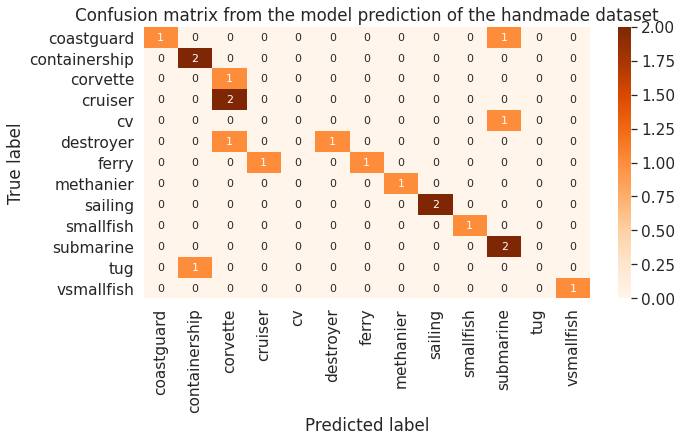

In [56]:
# compute the confusion matrix of the model
y_pred_bis = model.predict(test_bis_generator).argmax(axis=1)
conf_matrix = confusion_matrix(test_bis_generator.classes, y_pred_bis)

# Plot the confusion matrix
my_plot_confusion_matrix(conf_matrix, label_to_category_bis.values(),
                         title="Confusion matrix from the model prediction of the handmade dataset")

# Print the classification report
print(classification_report(test_bis_generator.classes,
                            y_pred_bis,
                            target_names=label_to_category_bis.values()))

The model accuracy on this dataset is only 65%. It is lower than on the test dataset. Images might be different from the test dataset (orientation, quality, shapes...) which might lead to this lower accuracy. 

In [57]:
!rm -rf more_ships